# Self-Driving Car Engineer Nanodegree


## Project 1: Finding Lane Lines on the Road

## Import packages, read an Image and display its gray version

This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


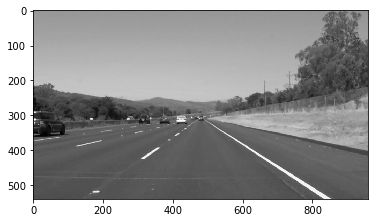

In [44]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2  #bringing in OpenCV libraries
import numpy as np
import os
import math

#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

# Create output image to draw lines over it
imageo = np.copy(image)

# print out some stats
print('This image is: ',type(image), 'with dimensions:', image.shape)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #grayscale conversion
# print out image
#plt.imshow(image) #original

plt.imshow(gray, cmap='gray') #grayscale image
plt.show()

## Apply Canny Edge detection

Here we are applying Canny to the image gray and the output will be another image called edges. low_threshold and high_threshold are your thresholds for edge detection ( Suggested ratio should be 1:2 or 1:3).

Canny Edge algorithm will first detect strong edge (strong gradient) pixels above the high_threshold, and reject pixels below the low_threshold. Next, pixels with values between the low_threshold and high_threshold will be included as long as they are connected to strong edges. The output edges is a binary image with white pixels tracing out the detected edges and black everywhere else.

It is recommended to apply Gaussian smoothing before running Canny. Gaussian smoothing is a way of suppressing noise and spurious gradients by averaging. The kernel_size for Gaussian smoothing to be any odd number. A larger kernel_size implies averaging or smoothing over a larger area.

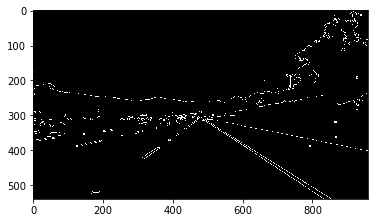

In [45]:
# Define a kernel size for Gaussian smoothing / blurring
kernel_size = 5 # Must be an odd number (3, 5, 7...)
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

# Define our parameters for Canny and run it
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Display the image
plt.imshow(edges, cmap='Greys_r')
plt.show()

## Hough Transform

Using Hough Transform to find lines from Canny Edge. Now, we have an image of white dots as output from Canny Edge, looking for a method to connect these dots to find the lines( Since we can connect dots looking for any shape), so we will use the line mathematical modeling for that (Y=aX+b).

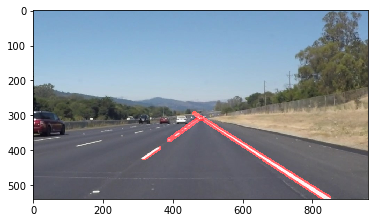

In [46]:
# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = 255   

# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(100,530),(916, 537), (450, 290), (490, 290)]], dtype=np.int32)
#vertices = np.array([[(0,imshape[0]),(450, 290), (490, 290), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15    # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40 #minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
        

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the original image
lines_edges = cv2.addWeighted(line_image, 0.8, imageo, 1, 0) 

plt.imshow(lines_edges)
cv2.imwrite('test_images_output/SolidWhiteRightOut.jpg',lines_edges)
plt.show()

## Drawing two continous lines for left and right.
 
 Now, our goal is to go from the above image to something similar to this image.
 
 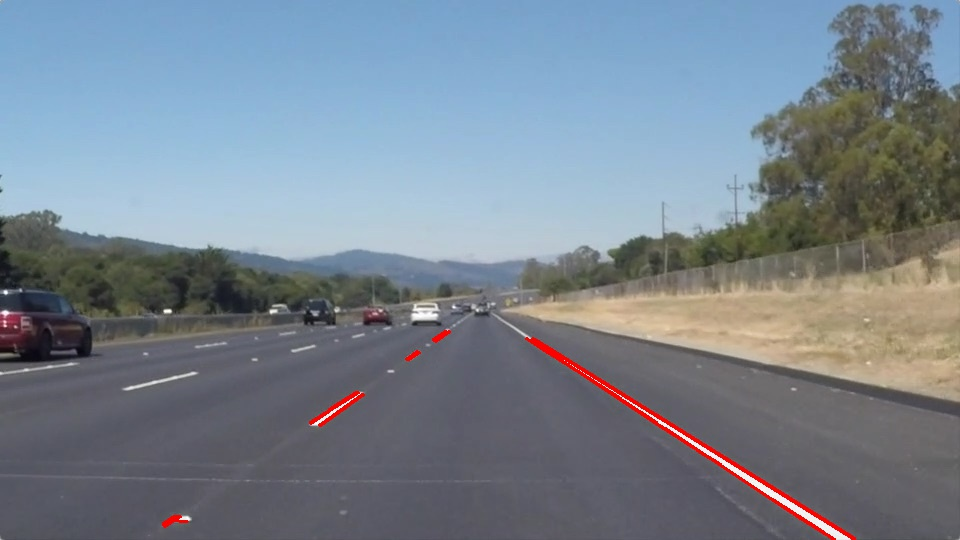
 
 We already drew all the lines we can find from hough through the selected region, but now we want only two lines. One on the left and one on the right. First, we can see that the slope for left line is negative and the slope for the right line is positive. (When x increase and y increase, the slope is positive). 
The used Algorithm is :
 1)  Loop though all the lines and find all the slopes
 2)  Make an array of left slops and right slops.
 3)  Put the positive and negative number into the correct array.
 Note: Since some lines don't belong to left or right, so consider a slope with difference margin 0.1 from left or right, otherwise, ignore. 
 4)  Calculate left and right slope average.
 5) For every line, Calculate the y- intersection, so we can use the point with the minimum y-value as the 2nd point to draw the line. Since the line we draw must start at the botton edge of the image( subistitute in the equation Y=mX+b).
 
 Note: to draw the line from 2- points we use the line mathematical formula Y= mX+b, In the equation of a straight line (when the equation is written as "y = mx + b"), the slope is the number "m" ( which is calculated in our Algorithm for both left and right lines), and "b" is the y-intercept (that is, the point where the line crosses the vertical y-axis).



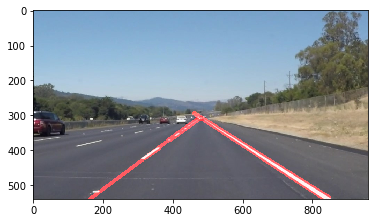

In [47]:
leftM = 0
rightM = 0
findSample = 0 # find flag
slopeDifference = 0.2
for line in lines:
    for x1, y1, x2, y2 in line:
        for newline in lines:
            for a1, b1, a2, b2 in newline:
                if x1 == a1 and y1 == b1 and x2 == a2 and y2 == b2: 
                    # all the same, ignore
                    continue
                m1 = ((y2-y1)/(x2-x1))
                m2 = ((b2-b1)/(a2-a1))
                if m1 > 0 and m2 < 0:
                    leftM = m1
                    rightM = m2
                    #print("leftM = %f, rightM = %f" %(leftM, rightM))
                    findSample = 1
                if m1 < 0 and m2 > 0:
                    leftM = m2
                    rightM = m1
                    #print("leftM = %f, rightM = %f" %(leftM, rightM))
                    findSample = 1
                else:
                    continue
                    
                if findSample == 1: break
            if findSample == 1: break
        if findSample == 1: break
    if findSample == 1: break

leftLinePoints = []
rightLinePoints = []
for line in lines:
    for x1, y1, x2, y2 in line:
        m = ((y2-y1)/(x2-x1))
        if abs(m - rightM) <= slopeDifference:
            #right line points
            rightLinePoints.append((x1, y1))
            rightLinePoints.append((x2, y2))
        elif abs(m - leftM) <= slopeDifference:
            #left line points
            leftLinePoints.append((x1, y1))
            leftLinePoints.append((x2, y2))
        else:
            continue
        
# find smallest points in left
# get array of y points for leftPoints
leftYPoints = list(map(lambda x: x[1], leftLinePoints))
minLeftYPoints = min(leftYPoints)
maxLeftYPoints = max(leftYPoints)

minLeftPoints = list(filter(lambda x: x[1] == minLeftYPoints, leftLinePoints))[0]
maxLeftPoints = list(filter(lambda x: x[1] == maxLeftYPoints, leftLinePoints))[0]

# get array of y points for rightPoints
rightYPoints = list(map(lambda x: x[1], rightLinePoints))
minRightYPoints = min(rightYPoints)
maxRightYPoints = max(rightYPoints)

minRightPoints = list(filter(lambda x: x[1] == minRightYPoints, rightLinePoints))[0]
maxRightPoints = list(filter(lambda x: x[1] == maxRightYPoints, rightLinePoints))[0]

# calculate final slope
final_left_m = (maxLeftPoints[1] - minLeftPoints[1]) / (maxLeftPoints[0] - minLeftPoints[0])
final_left_b = (minLeftPoints[1] - (final_left_m * minLeftPoints[0]))
final_right_m = (maxRightPoints[1] - minRightPoints[1]) / (maxRightPoints[0] - minRightPoints[0])
final_right_b = (minRightPoints[1] - (final_right_m * minRightPoints[0]))

height, width, channels = image.shape
final_left_point = (height - final_left_b) / final_left_m
final_right_point = (height - final_right_b) / final_right_m
cv2.line(line_image, minLeftPoints, (int(final_left_point), height), (255,0,0), 10)
cv2.line(line_image, minRightPoints, (int(final_right_point), height), (255,0,0), 10)
 
# Draw the lines on the original image
lines_edges = cv2.addWeighted(line_image, 0.8, imageo, 1, 0) 

plt.imshow(lines_edges)
cv2.imwrite('test_images_output/SolidWhiteRightOut.jpg',lines_edges)
plt.show()

## Lane detecting Pipeline in a function form

In [48]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) 
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    # Create output image to draw lines over it
    imageo = np.copy(image)
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #grayscale conversion
    
    # Define a kernel size for Gaussian smoothing / blurring
    kernel_size = 5 # Must be an odd number (3, 5, 7...)
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    # Define our parameters for Canny and run it
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    
    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(100,530),(916, 537), (450, 290), (490, 290)]], dtype=np.int32)
    #vertices = np.array([[(0,imshape[0]),(450, 290), (490, 290), (imshape[1],imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 #minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)    
    
    # Combine the line segments to get two continous left and right lines
    leftM = 0
    rightM = 0
    findSample = 0 # find flag
    slopeDifference = 0.2
    for line in lines:
        for x1, y1, x2, y2 in line:
            for newline in lines:
                for a1, b1, a2, b2 in newline:
                    if x1 == a1 and y1 == b1 and x2 == a2 and y2 == b2: 
                    # all the same, ignore
                     continue
                    m1 = ((y2-y1)/(x2-x1))
                    m2 = ((b2-b1)/(a2-a1))
                    if m1 > 0 and m2 < 0:
                        leftM = m1
                        rightM = m2
                        #print("leftM = %f, rightM = %f" %(leftM, rightM))
                        findSample = 1
                    if m1 < 0 and m2 > 0:
                        leftM = m2
                        rightM = m1
                        #print("leftM = %f, rightM = %f" %(leftM, rightM))
                        findSample = 1
                    else:
                        continue
                    
                    if findSample == 1: break
                if findSample == 1: break
            if findSample == 1: break
        if findSample == 1: break
    leftLinePoints = []
    rightLinePoints = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            m = ((y2-y1)/(x2-x1))
            if abs(m - rightM) <= slopeDifference:
              #right line points
                rightLinePoints.append((x1, y1))
                rightLinePoints.append((x2, y2))
            elif abs(m - leftM) <= slopeDifference:
                #left line points
                leftLinePoints.append((x1, y1))
                leftLinePoints.append((x2, y2))
            else:
                continue
        
     # find smallest points in left
    # get array of y points for leftPoints
    leftYPoints = list(map(lambda x: x[1], leftLinePoints))
    minLeftYPoints = min(leftYPoints)
    maxLeftYPoints = max(leftYPoints)

    minLeftPoints = list(filter(lambda x: x[1] == minLeftYPoints, leftLinePoints))[0]
    maxLeftPoints = list(filter(lambda x: x[1] == maxLeftYPoints, leftLinePoints))[0]

    # get array of y points for rightPoints
    rightYPoints = list(map(lambda x: x[1], rightLinePoints))
    minRightYPoints = min(rightYPoints)
    maxRightYPoints = max(rightYPoints)

    minRightPoints = list(filter(lambda x: x[1] == minRightYPoints, rightLinePoints))[0]
    maxRightPoints = list(filter(lambda x: x[1] == maxRightYPoints, rightLinePoints))[0]

    # calculate final slope
    final_left_m = (maxLeftPoints[1] - minLeftPoints[1]) / (maxLeftPoints[0] - minLeftPoints[0])
    final_left_b = (minLeftPoints[1] - (final_left_m * minLeftPoints[0]))
    final_right_m = (maxRightPoints[1] - minRightPoints[1]) / (maxRightPoints[0] - minRightPoints[0])
    final_right_b = (minRightPoints[1] - (final_right_m * minRightPoints[0]))

    height, width, channels = image.shape
    final_left_point = (height - final_left_b) / final_left_m
    final_right_point = (height - final_right_b) / final_right_m
    cv2.line(line_image, minLeftPoints, (int(final_left_point), height), (255,0,0), 10)
    cv2.line(line_image, minRightPoints, (int(final_right_point), height), (255,0,0), 10)
 
    # Draw the lines on the original image
    lines_edges = cv2.addWeighted(line_image, 0.8, imageo, 1, 0) 
    
    return lines_edges

    
    

###  Function to save images into output file

In [49]:
def save_img(img,img_name):
    cv2.imwrite('test_images_output/'+img_name,img)
    

###  Function to display images 

In [50]:
def display_img(img):
    plt.imshow(img)
    plt.show()

# Testing on test_images

Testing our Algorithm on the given test_images. In this part, I will run the lane detecting pipeline on all images given in test_images folder and save the output to test_images_output folder in the same directory. 

In [51]:
os.listdir("test_images")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

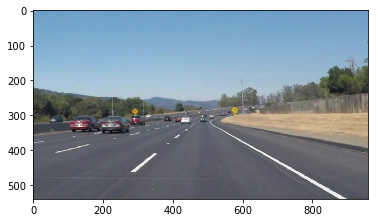

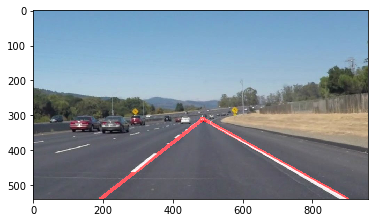

In [52]:
## Running code on 'solidWhiteCurve.jpg'
#reading in an image
image_name= 'solidWhiteCurve.jpg'
image = mpimg.imread('test_images/'+image_name)
#Display image before detecting lines
display_img(image)
#Run pipline
out_image= process_image(image)
#Display image after detecting lines
display_img(out_image)
#Saving output image to the test_images_out folder
save_img(out_image,image_name)

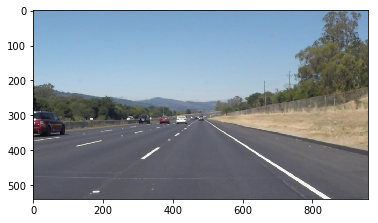

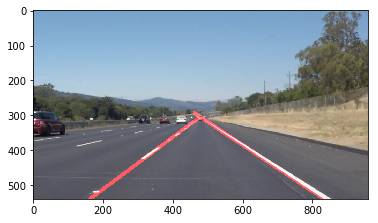

In [53]:
## Running code on 'solidWhiteRight.jpg'
#reading in an image
image_name= 'solidWhiteRight.jpg'
image = mpimg.imread('test_images/'+image_name)
#Display image before detecting lines
display_img(image)
#Run pipline
out_image= process_image(image)
#Display image after detecting lines
display_img(out_image)
#Saving output image to the test_images_out folder
save_img(out_image,image_name)

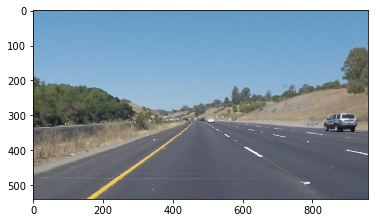

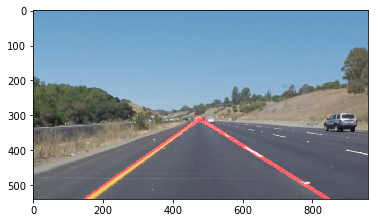

In [54]:
## Running code on 'solidYellowCurve.jpg'
#reading in an image
image_name= 'solidYellowCurve.jpg'
image = mpimg.imread('test_images/'+image_name)
#Display image before detecting lines
display_img(image)
#Run pipline
out_image= process_image(image)
#Display image after detecting lines
display_img(out_image)
#Saving output image to the test_images_out folder
save_img(out_image,image_name)

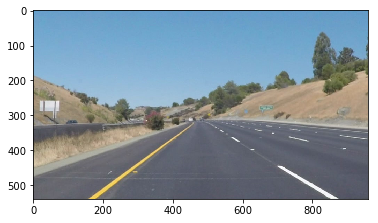

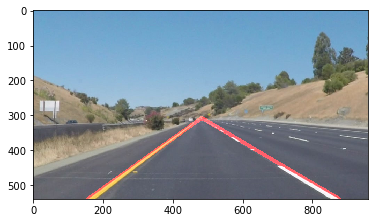

In [55]:
## Running code on 'solidYellowCurve2.jpg'
#reading in an image
image_name= 'solidYellowCurve2.jpg'
image = mpimg.imread('test_images/'+image_name)
#Display image before detecting lines
display_img(image)
#Run pipline
out_image= process_image(image)
#Display image after detecting lines
display_img(out_image)
#Saving output image to the test_images_out folder
save_img(out_image,image_name)

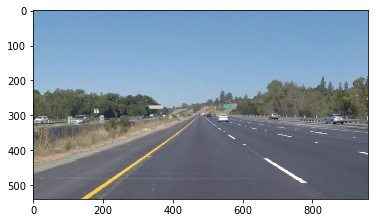

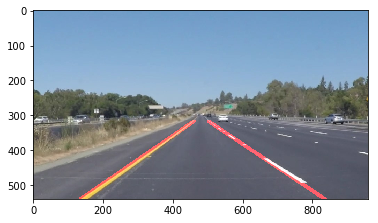

In [56]:
## Running code on 'solidYellowLeft.jpg'
#reading in an image
image_name= 'solidYellowLeft.jpg'
image = mpimg.imread('test_images/'+image_name)
#Display image before detecting lines
display_img(image)
#Run pipline
out_image= process_image(image)
#Display image after detecting lines
display_img(out_image)
#Saving output image to the test_images_out folder
save_img(out_image,image_name)

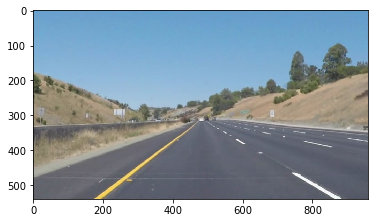

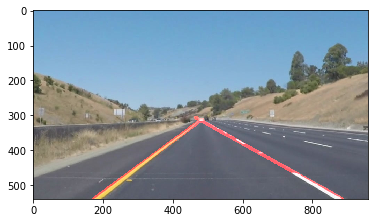

In [57]:
## Running code on 'whiteCarLaneSwitch.jpg'
#reading in an image
image_name= 'whiteCarLaneSwitch.jpg'
image = mpimg.imread('test_images/'+image_name)
#Display image before detecting lines
display_img(image)
#Run pipline
out_image= process_image(image)
#Display image after detecting lines
display_img(out_image)
#Saving output image to the test_images_out folder
save_img(out_image,image_name)

## Test On Videos

In [58]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML